# imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ignore convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")

2024-05-01 18:22:45.517371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# data importation

In [2]:
closures = pd.read_csv("UWM Closures.csv")
weather_1 = pd.read_csv("UWM Primary.csv")
hourly = pd.read_csv("UWM Hourly Data.csv")

print(closures.info(), weather_1.info(), hourly.info())
#13 expected closures
#20088 weather data points

/var/folders/fh/dvn_79bs6b58szfg1vfz4g740000gn/T/ipykernel_5430/1598324000.py:2: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_1 = pd.read_csv("UWM Primary.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          13 non-null     object
 1   Closure Type  13 non-null     object
dtypes: object(2)
memory usage: 340.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          20088 non-null  object 
 1   NAME             20088 non-null  object 
 2   LATITUDE         20088 non-null  float64
 3   LONGITUDE        20088 non-null  float64
 4   ELEVATION        20088 non-null  float64
 5   DATE             20088 non-null  object 
 6   PRCP             20088 non-null  float64
 7   PRCP_ATTRIBUTES  20088 non-null  object 
 8   SNOW             20061 non-null  float64
 9   SNOW_ATTRIBUTES  20061 non-null  object 
 10  SNWD             20

# data pre-processing - date/time

In [3]:
weather_1['DATE'] = pd.to_datetime(weather_1['DATE'], yearfirst = True, format= '%Y-%m-%d')
closures['DATE'] = pd.to_datetime(closures['DATE'], dayfirst = True, format = '%m/%d/%y')
hourly['DATE'] = pd.to_datetime(hourly['DATE'], format = '%Y%m%d %H:%M')

print(weather_1['DATE'].value_counts(), closures['DATE'].value_counts(), hourly['DATE'].value_counts())

DATE
1965-01-01    1
2001-08-29    1
2001-09-05    1
2001-09-04    1
2001-09-03    1
             ..
1983-05-02    1
1983-05-01    1
1983-04-30    1
1983-04-29    1
2019-12-31    1
Name: count, Length: 20088, dtype: int64 DATE
2065-03-17    1
1978-01-26    1
1987-12-15    1
1990-12-03    1
1994-01-18    1
2008-02-06    1
2009-12-09    1
2011-02-02    1
2012-12-20    1
2014-01-28    1
2019-01-29    1
2019-01-30    1
2019-01-31    1
Name: count, dtype: int64 DATE
1965-01-01 01:00:00    1
2004-01-17 02:00:00    1
2004-01-14 16:00:00    1
2004-01-14 17:00:00    1
2004-01-14 18:00:00    1
                      ..
1990-01-04 00:00:00    1
1990-01-04 01:00:00    1
1990-01-04 02:00:00    1
1990-01-04 03:00:00    1
2013-12-31 22:00:00    1
Name: count, Length: 41948, dtype: int64


In [4]:
import datetime
def fix_date(x):

    if x.year > 2024:

        year = x.year - 100

    else:

        year = x.year

    return datetime.date(year,x.month,x.day)

weather_1['DATE']=weather_1['DATE'].apply(fix_date)
weather_1['DATE']=pd.to_datetime(weather_1['DATE'], format='%Y-%m-%d')

closures['DATE'] = closures['DATE'].apply(fix_date)
closures['DATE'] = pd.to_datetime(closures['DATE'], format = '%m/%d/%y')

print (closures.info(), closures.head())
print(weather_1.info(), weather_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE          13 non-null     datetime64[ns]
 1   Closure Type  13 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 340.0+ bytes
None         DATE     Closure Type
0 1965-03-17           closed
1 1978-01-26  early dismissal
2 1987-12-15  early dismissal
3 1990-12-03  early dismissal
4 1994-01-18  early dismissal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   STATION          20088 non-null  object        
 1   NAME             20088 non-null  object        
 2   LATITUDE         20088 non-null  float64       
 3   LONGITUDE        20088 non-null  float64       
 4   ELEVATION        

# data join 

In [5]:
weather = pd.concat([weather_1])
og = pd.merge(closures, weather, how='right', on='DATE')
print(og.head(), og.info(), og['DATE'].value_counts(), og['NAME'].value_counts(), og['Closure Type'].value_counts())
#20088 weather points #13 closures

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 59 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             20088 non-null  datetime64[ns]
 1   Closure Type     13 non-null     object        
 2   STATION          20088 non-null  object        
 3   NAME             20088 non-null  object        
 4   LATITUDE         20088 non-null  float64       
 5   LONGITUDE        20088 non-null  float64       
 6   ELEVATION        20088 non-null  float64       
 7   PRCP             20088 non-null  float64       
 8   PRCP_ATTRIBUTES  20088 non-null  object        
 9   SNOW             20061 non-null  float64       
 10  SNOW_ATTRIBUTES  20061 non-null  object        
 11  SNWD             20021 non-null  float64       
 12  SNWD_ATTRIBUTES  20021 non-null  object        
 13  TMAX             20088 non-null  int64         
 14  TMAX_ATTRIBUTES  20088 non-null  objec

In [6]:
date_range=pd.date_range('1961-01-01', '2021-12-31')
missing_dates=date_range[~date_range.isin(og['DATE'])]
winter_missing_dates = missing_dates[missing_dates.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates, winter_missing_dates)
#2192 missing dates
#1460 missing winter weather days

DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=2192, freq=None) DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=1460, freq=None)


# variables drops/additions/renames/filling null values

In [7]:
#remove unnecessary categories like all attribute data, time of observation, elevation, long/lat, and values that not all weather data had
dropped = og.drop(columns=['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'PRCP_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'SNOW_ATTRIBUTES','SNWD_ATTRIBUTES', 'WT01_ATTRIBUTES', 'WT02_ATTRIBUTES', 'WESD_ATTRIBUTES', 'WT03_ATTRIBUTES', 'WT04_ATTRIBUTES', 'WT05_ATTRIBUTES', 'WT06_ATTRIBUTES', 'WT07_ATTRIBUTES', 'WT08_ATTRIBUTES', 'WT09_ATTRIBUTES', 'WT15_ATTRIBUTES', 'WT16_ATTRIBUTES', 'WT17_ATTRIBUTES', 'WT18_ATTRIBUTES', 'WT11_ATTRIBUTES', 'WT14_ATTRIBUTES', 'WT07', 'WT08', 'WT17',  'WT02', 'WT09', 'WT14', 'WT15', 'WT16', 'WT18', 'WT21_ATTRIBUTES', 'WT22_ATTRIBUTES', 'WT10_ATTRIBUTES', 'WT13_ATTRIBUTES', 'WT19_ATTRIBUTES', 'WT19', 'WT21'])

#rename
dropped.rename(columns={'MDSF': 'MultidaySnowfallTotal', 'PRCP': 'PrecipitationTotal', 'SNOW':'SnowfallTotal', 'SNWD': 'SnowDepth', 'TMAX':'MaxTemp', 'TMIN':'MinTemp', 'WESD':'WaterEqGroundSnow', 'WT01':'Fog/IceFog/FreezingFog', 'WT03': 'Thunder', 'WT04': 'Ice/Sleet', 'WT05':'Hail', 'WT06':'Glaze','WT11': 'HighWinds','WESF':'WaterEqSnowfall', 'NAME':'Station', 'WT10':'Tornado', 'WT13':'Mist', 'WT22': 'IceFog'}, inplace=True)

In [8]:
#add day, month, year, and day of the week variables
add=dropped.sort_values(by='DATE')
add['Day']=dropped['DATE'].dt.day
add['Day of the Week']=add['DATE'].dt.day_name()
add['Month']=add['DATE'].dt.month
add['Year']=add['DATE'].dt.year

In [9]:
#add dummy variable for early dismissal the day before
add=add.sort_values(by='DATE')
target = 'early dismissal'
add['Previous Early Dismissal'] = add['Closure Type'].apply(lambda x: 1 if x==target else 0)
add['Previous Early Dismissal'] =add['Previous Early Dismissal'].shift(1)
add['Previous Early Dismissal'].fillna(0, inplace=True)

#add school year variable
add=add.sort_values(by='DATE')
add['School Year'] = add['DATE'].dt.year-(add['DATE'].dt.month<7)
add['School Year'] = add['School Year'].astype(int)

#add a shift in closures (to eventually create a cumsum of school days in the year)
add=add.sort_values(by='DATE')
add['Closure_shift']=add['Closure Type'].shift(+1).fillna(0)

In [10]:
#add mapping categorical variables
closure_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1,
                  'virtual snow day' : 1}

closureshift_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1,
                    'virtual snow day' : 1, 
                       '0':0}

weekday_mapping = {'Monday': 0, 
                  'Tuesday' : 1, 
                  'Wednesday': 2, 
                  'Thursday':3, 
                  'Friday': 4,
                  'Saturday': 5, 
                  'Sunday':6}
station_mapping = {'HOLLAND, MI US': 0,
                  'GRAND RAPIDS GERALD R FORD INTERNATIONAL AIRPORT, MI US':1,
                  'HOLLAND 3.9 NNE, MI US':2}
add['Closure Type']=add['Closure Type'].map(closure_mapping)
add['Day of the Week']=add['Day of the Week'].map(weekday_mapping)
add['Station']=add['Station'].map(station_mapping)
add['Closure_shift']=add['Closure_shift'].map(closureshift_mapping)

#add total school days in the year
grouped=add.groupby('School Year')
add['Snow Days This Year']=grouped['Closure_shift'].cumsum()

In [11]:
#change all numerical data types of int64
add['WaterEqGroundSnow']=add['WaterEqGroundSnow'].astype('float64')
add['SnowfallTotal']=add['SnowfallTotal'].astype('float64')
add['SnowDepth']=add['SnowDepth'].astype('float64')
add['PrecipitationTotal']=add['PrecipitationTotal'].astype('float64')

#fill null values strategically
add['MaxTemp']=add["MaxTemp"].interpolate()
add['MinTemp']=add["MinTemp"].interpolate()

#fill the rest of the null values
add=add.fillna(0)

add['Snow Days This Year'].value_counts()

Snow Days This Year
0.0    20075
1.0       11
2.0        1
3.0        1
Name: count, dtype: int64

In [12]:
#add previous day's weather data
wprevious=add.sort_values(by='DATE')
wprevious['Previous_MinTemp']=wprevious['MinTemp'].shift(1)
wprevious['Previous_MaxTemp']=wprevious['MaxTemp'].shift(1)
wprevious['Previous_SnowfallTotal']=wprevious['SnowfallTotal'].shift(1)
wprevious['Previous_SnowDepth']=wprevious['SnowDepth'].shift(1)
wprevious.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      20088 non-null  datetime64[ns]
 1   Closure Type              20088 non-null  float64       
 2   Station                   20088 non-null  float64       
 3   PrecipitationTotal        20088 non-null  float64       
 4   SnowfallTotal             20088 non-null  float64       
 5   SnowDepth                 20088 non-null  float64       
 6   MaxTemp                   20088 non-null  int64         
 7   MinTemp                   20088 non-null  int64         
 8   WaterEqGroundSnow         20088 non-null  float64       
 9   Fog/IceFog/FreezingFog    20088 non-null  float64       
 10  Thunder                   20088 non-null  float64       
 11  Ice/Sleet                 20088 non-null  float64       
 12  Hail              

In [13]:
#add vectorlike data over 3 day period
vector=wprevious.sort_values(by='DATE')
vector['MinTempChange']=vector['MinTemp'].diff()
vector['MaxTempChange']=vector['MaxTemp'].diff()
vector['SnowfallTotalChange']=vector['SnowfallTotal'].diff()
vector['SnowDepthChange']=vector['SnowDepth'].diff()
vector['3DayVector_MinTemp']=vector['MinTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_MaxTemp']=vector['MaxTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowfallTotal']=vector['SnowfallTotalChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowDepth']=vector['SnowDepthChange'].rolling(window=3, min_periods=1).mean()
vector=vector.fillna(0)

vector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      20088 non-null  datetime64[ns]
 1   Closure Type              20088 non-null  float64       
 2   Station                   20088 non-null  float64       
 3   PrecipitationTotal        20088 non-null  float64       
 4   SnowfallTotal             20088 non-null  float64       
 5   SnowDepth                 20088 non-null  float64       
 6   MaxTemp                   20088 non-null  int64         
 7   MinTemp                   20088 non-null  int64         
 8   WaterEqGroundSnow         20088 non-null  float64       
 9   Fog/IceFog/FreezingFog    20088 non-null  float64       
 10  Thunder                   20088 non-null  float64       
 11  Ice/Sleet                 20088 non-null  float64       
 12  Hail              

# get rid of common breaks from school

In [14]:
#get rid of summer data
school = vector[~vector.DATE.dt.month.isin([6, 7, 8, 9])]

#get rid of winter break
school = school[~((school['Month']==12) & (school['Day']>22))]
school=school[~((school['Month']==1) & (school['Day']<3))]

#get rid of weekends
school=school[school['DATE'].dt.weekday<5]

#get rid of federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=school['DATE'].min(), end=school['DATE'].max())
school=school[~school['DATE'].isin(holidays)]

#get rid of fri of thanksgiving
bday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
def get_thanksgiving_dates(year):
    # Find the fourth Thursday of November
    thanksgiving_date = pd.Timestamp(year, 11, 1) + relativedelta(weekday=4, weeks=3)
    # Get the dates for the day before and after Thanksgiving
    pre_thanksgiving = thanksgiving_date - pd.Timedelta(days=1)
    post_thanksgiving = thanksgiving_date + pd.Timedelta(days=1)
    return [pre_thanksgiving, thanksgiving_date, post_thanksgiving]
thanksgiving_dates = []
for year in range(1961,2021):
    thanksgiving_dates.extend(get_thanksgiving_dates(year))
thanksgiving_dates = [parse(date.strftime('%Y-%m-%d')) for date in thanksgiving_dates]
school=school[~school['DATE'].isin(thanksgiving_dates)]


print(school.info(),school['Closure Type'].value_counts())
#expected amount of closures

<class 'pandas.core.frame.DataFrame'>
Index: 8753 entries, 3 to 20076
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      8753 non-null   datetime64[ns]
 1   Closure Type              8753 non-null   float64       
 2   Station                   8753 non-null   float64       
 3   PrecipitationTotal        8753 non-null   float64       
 4   SnowfallTotal             8753 non-null   float64       
 5   SnowDepth                 8753 non-null   float64       
 6   MaxTemp                   8753 non-null   int64         
 7   MinTemp                   8753 non-null   int64         
 8   WaterEqGroundSnow         8753 non-null   float64       
 9   Fog/IceFog/FreezingFog    8753 non-null   float64       
 10  Thunder                   8753 non-null   float64       
 11  Ice/Sleet                 8753 non-null   float64       
 12  Hail                    

In [15]:
missing_dates = closures[~closures['DATE'].isin(school['DATE'])]
missing_dates=missing_dates.drop('Closure Type', axis = 1)
missing_info = pd.merge(vector, missing_dates, on='DATE', how='right')
school = pd.concat([missing_info, school])
school['Closure Type'].value_counts()

Closure Type
0.0    8740
1.0      13
Name: count, dtype: int64

In [16]:
full = school.drop(columns=['DATE','MaxTempChange', 'MinTempChange', 'Closure_shift', 'SnowfallTotalChange', 'SnowDepthChange'])

# data visualization, correlations, and more drops

In [17]:
closure_weather = full[full["Closure Type"] == 1]

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


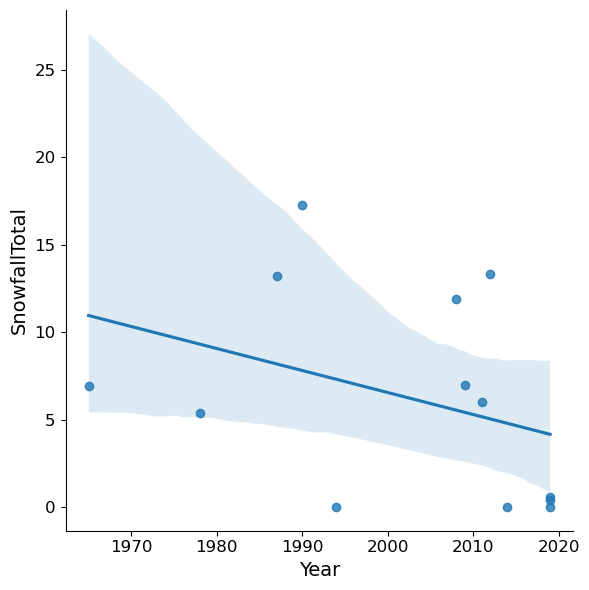

In [18]:
seaborn.lmplot( x="Year", y="SnowfallTotal", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


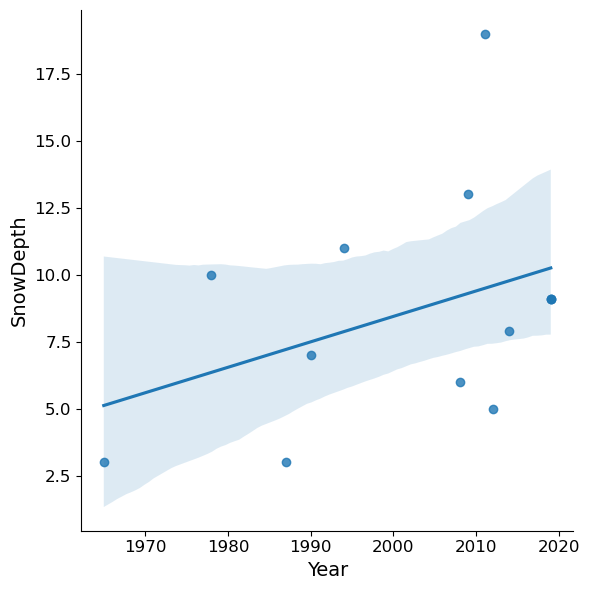

In [19]:
seaborn.lmplot( x="Year", y="SnowDepth", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


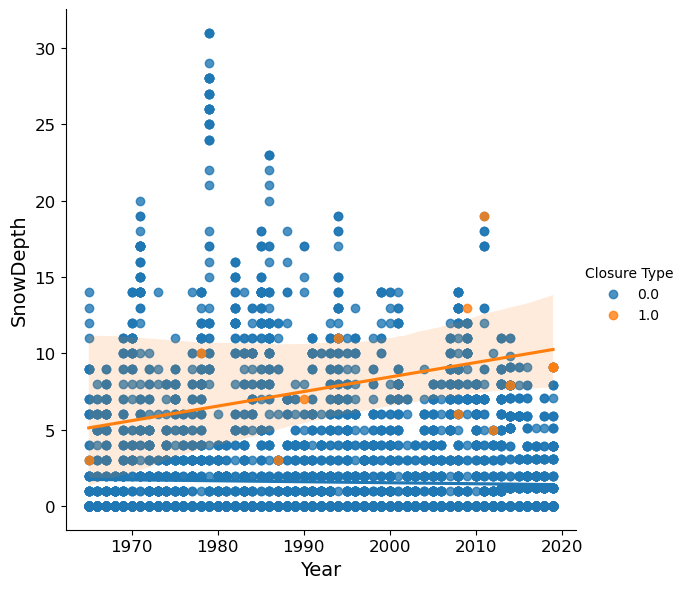

In [20]:
seaborn.lmplot( x="Year", y="SnowDepth", hue ="Closure Type",data = full, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


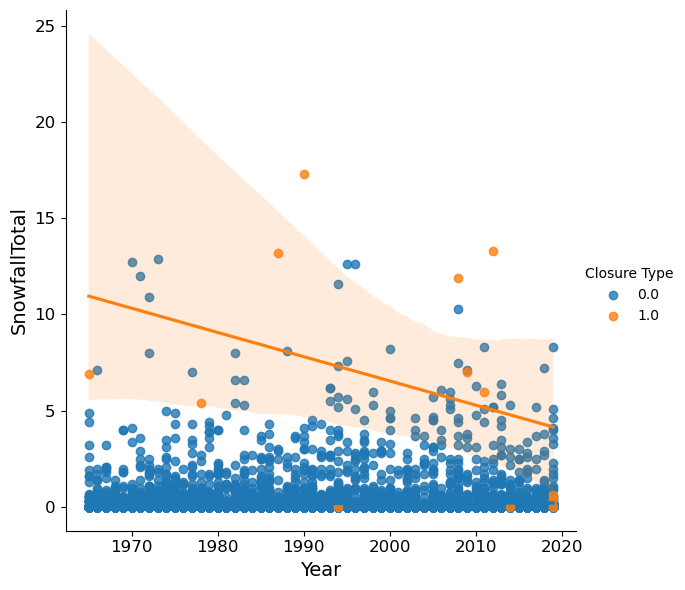

In [21]:
seaborn.lmplot( x="Year", y="SnowfallTotal", hue ="Closure Type",data = full, height = 6)

<Axes: xlabel='Day', ylabel='Month'>

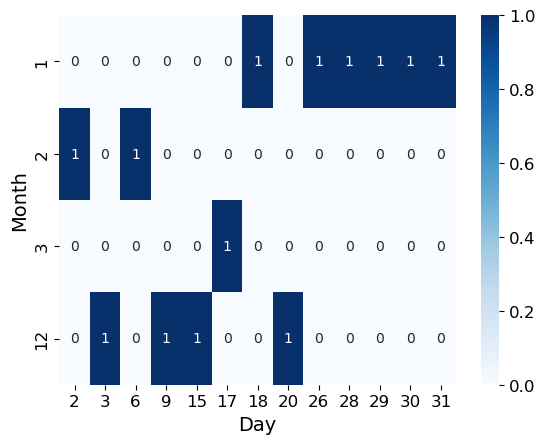

In [22]:
pivot_table = closure_weather.pivot_table(index = "Month", columns = "Day", aggfunc='size', fill_value=0)
seaborn.heatmap(pivot_table, annot=True, cmap='Blues', fmt ='d')

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


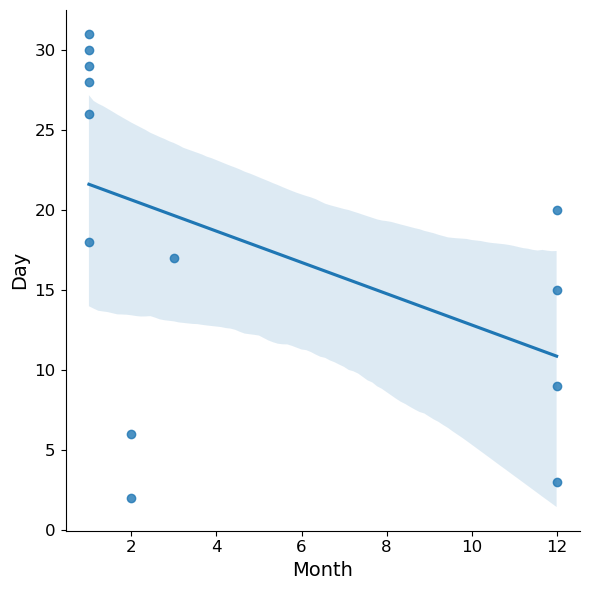

In [23]:
seaborn.lmplot( x="Month", y="Day", data=closure_weather, height=6)

In [24]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8753 entries, 3 to 20076
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Closure Type              8753 non-null   float64
 1   Station                   8753 non-null   float64
 2   PrecipitationTotal        8753 non-null   float64
 3   SnowfallTotal             8753 non-null   float64
 4   SnowDepth                 8753 non-null   float64
 5   MaxTemp                   8753 non-null   int64  
 6   MinTemp                   8753 non-null   int64  
 7   WaterEqGroundSnow         8753 non-null   float64
 8   Fog/IceFog/FreezingFog    8753 non-null   float64
 9   Thunder                   8753 non-null   float64
 10  Ice/Sleet                 8753 non-null   float64
 11  Hail                      8753 non-null   float64
 12  Glaze                     8753 non-null   float64
 13  Tornado                   8753 non-null   float64
 14  HighWinds   

In [25]:
full.corr()['Closure Type'].sort_values()

MaxTemp                    -0.062229
MinTemp                    -0.056119
Previous_MaxTemp           -0.053421
Previous_MinTemp           -0.050031
3DayVector_MaxTemp         -0.027070
3DayVector_MinTemp         -0.022833
Month                      -0.010511
Day of the Week            -0.007088
Hail                       -0.005444
HighWinds                  -0.000412
Glaze                       0.007907
Mist                        0.009460
Fog/IceFog/FreezingFog      0.011467
Ice/Sleet                   0.012211
Day                         0.012403
Thunder                     0.014865
WaterEqGroundSnow           0.016087
School Year                 0.024088
Year                        0.024194
IceFog                      0.027689
Previous_SnowDepth          0.042012
SnowDepth                   0.077216
PrecipitationTotal          0.078575
Previous_SnowfallTotal      0.080219
3DayVector_SnowDepth        0.106300
Previous Early Dismissal    0.112341
Snow Days This Year         0.168724
3

In [26]:
ready = full.drop(columns=['3DayVector_MaxTemp', '3DayVector_MinTemp', 'Thunder', 'Day','Day of the Week' , 'Hail', 'HighWinds', 'Ice/Sleet',  'Fog/IceFog/FreezingFog' , 'Month', 'Glaze', 'Mist', 'School Year', 'Thunder', 'Year', 'IceFog', 'WaterEqGroundSnow', 'Station', 'Tornado', 'Previous_SnowDepth'])

In [27]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.062229
MinTemp                    -0.056119
Previous_MaxTemp           -0.053421
Previous_MinTemp           -0.050031
SnowDepth                   0.077216
PrecipitationTotal          0.078575
Previous_SnowfallTotal      0.080219
3DayVector_SnowDepth        0.106300
Previous Early Dismissal    0.112341
Snow Days This Year         0.168724
3DayVector_SnowfallTotal    0.196425
SnowfallTotal               0.279949
Closure Type                1.000000
Name: Closure Type, dtype: float64

<Axes: >

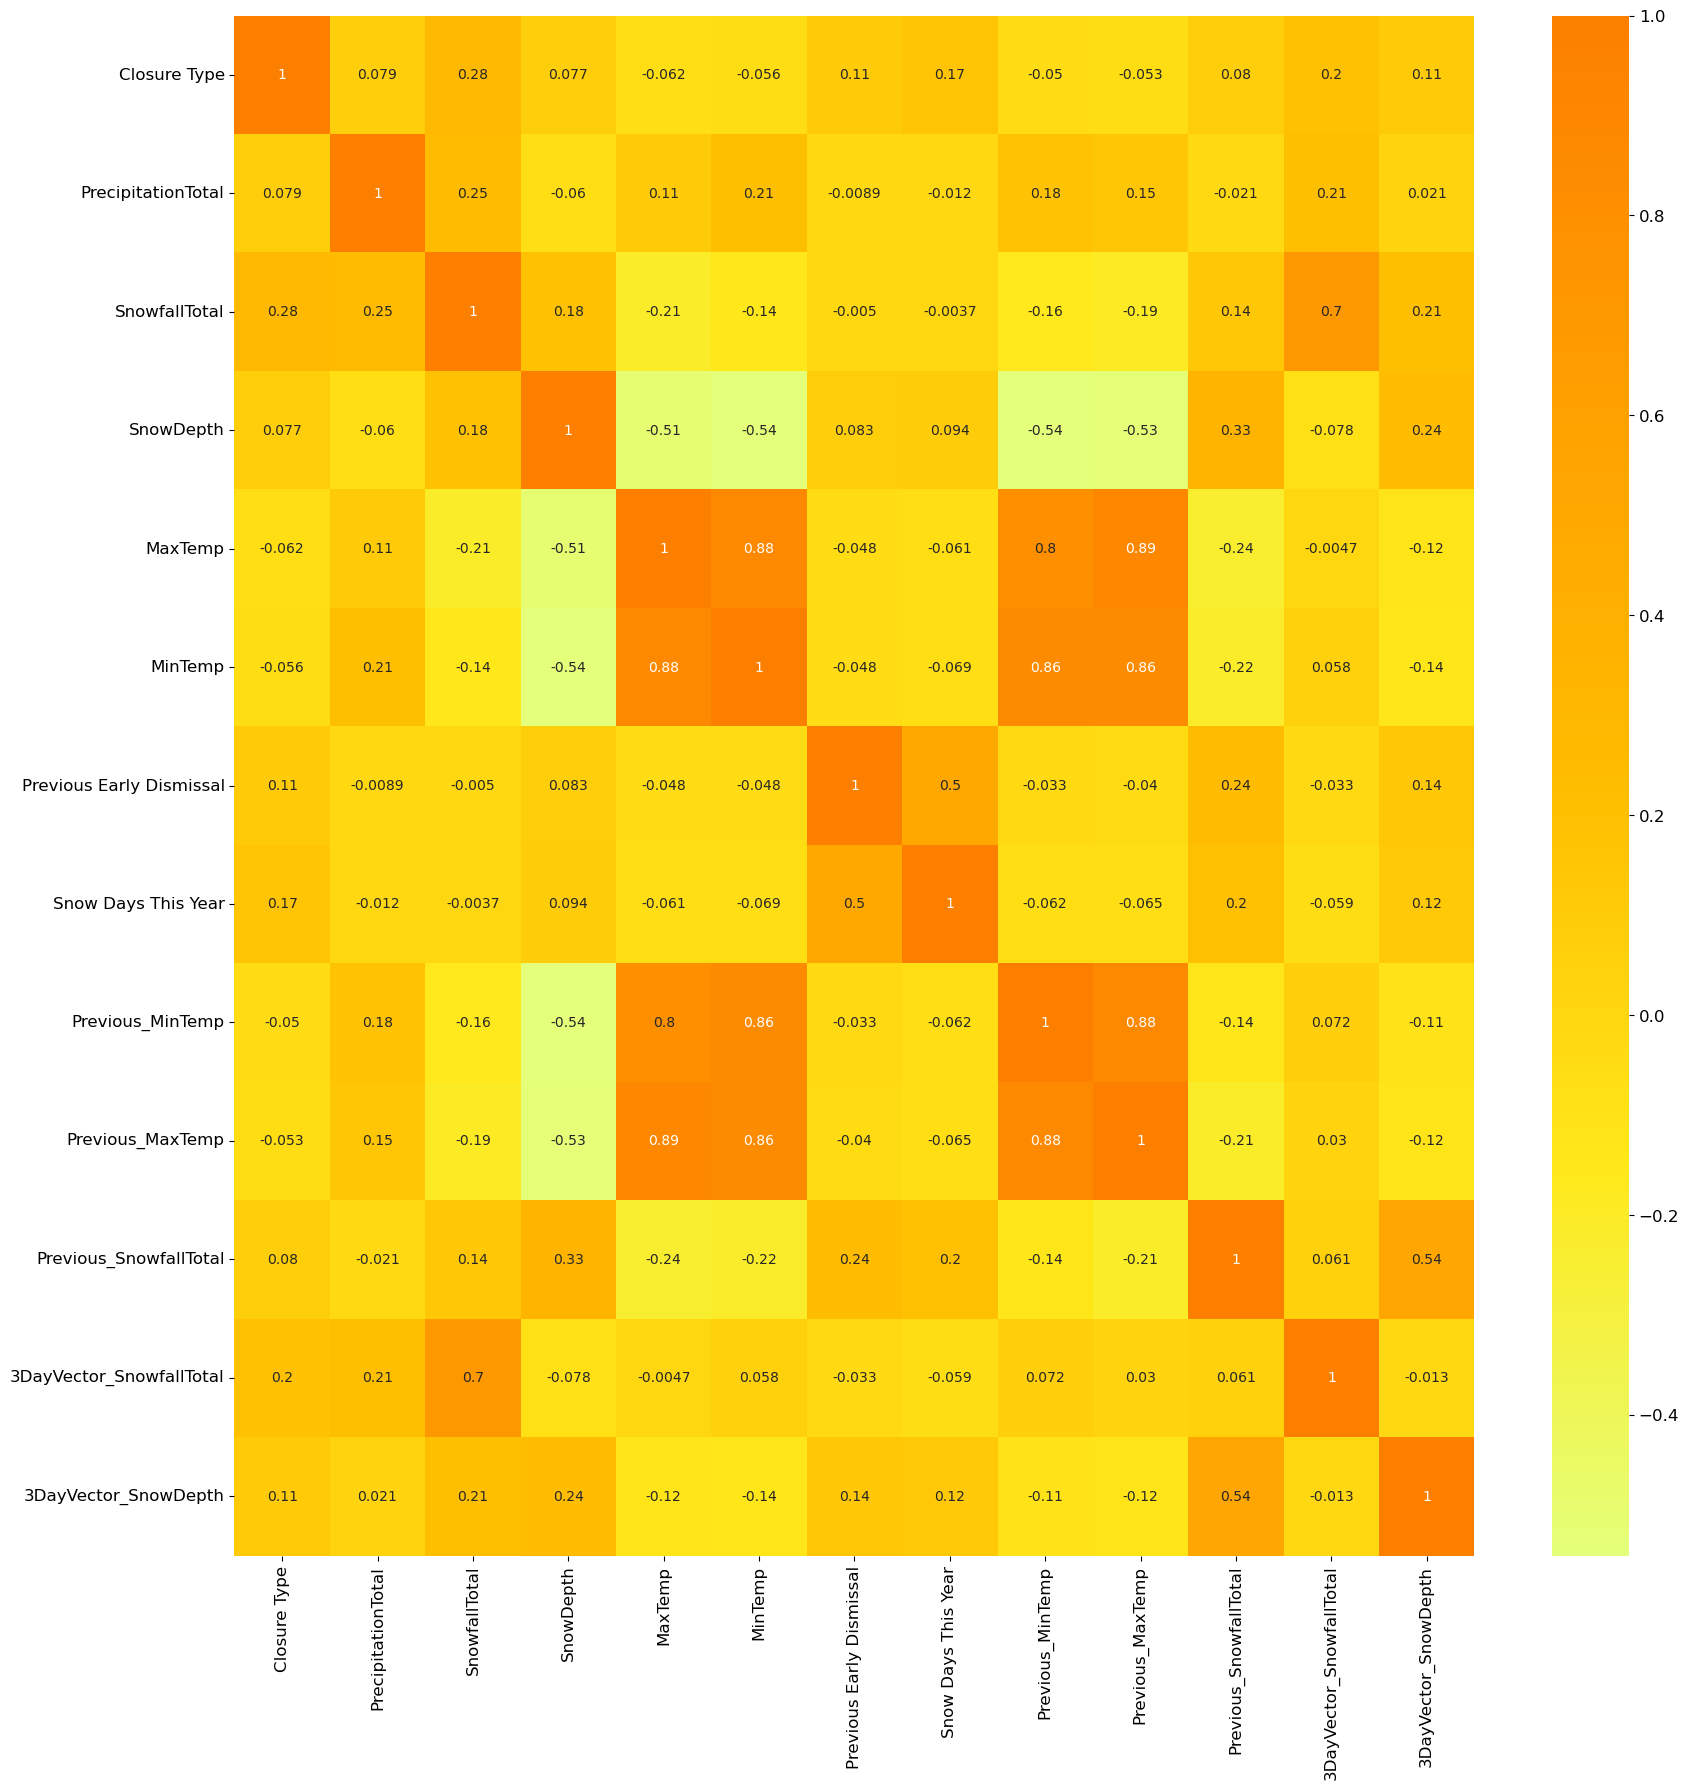

In [28]:
plt.figure(figsize=(20,20))
corr = ready.corr()
seaborn.heatmap(corr, cmap = 'Wistia', annot= True)

# data splitting

In [29]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.9846094591082896


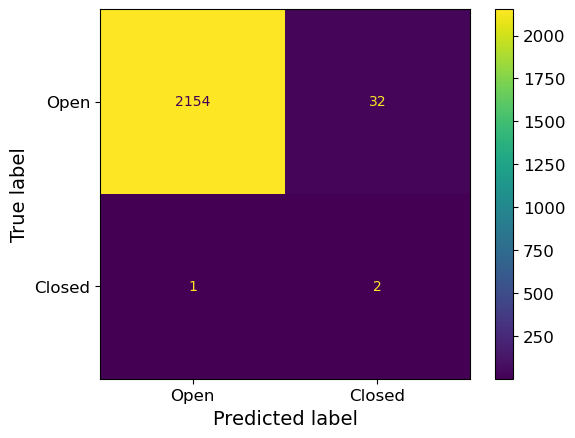

Test set accuracy score for Logistic Regression Model is  0.9849246231155779
Test set recall score for Logistic Regression Model is  0.6666666666666666
Test set precision score for Logistic Regression Model is  0.058823529411764705
Test set F1 score for Logistic Regression Model is  0.10810810810810811


In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree

In [33]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [34]:
dt_model = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 2, min_samples_split=2, random_state=42)
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9980196848201357


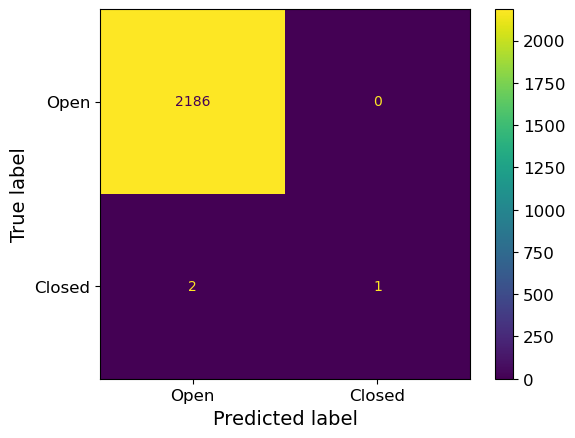

Test set accuracy score for Decision Tree Model is  0.9990863407948835
Test set recall score for Decision Tree Model is  0.3333333333333333
Test set precision score for Decision Tree Model is  1.0
Test set F1 score for Decision Tree Model is  0.5


In [35]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest

In [36]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [37]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 5, min_samples_leaf = 2, min_samples_split =5, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9981716597987897


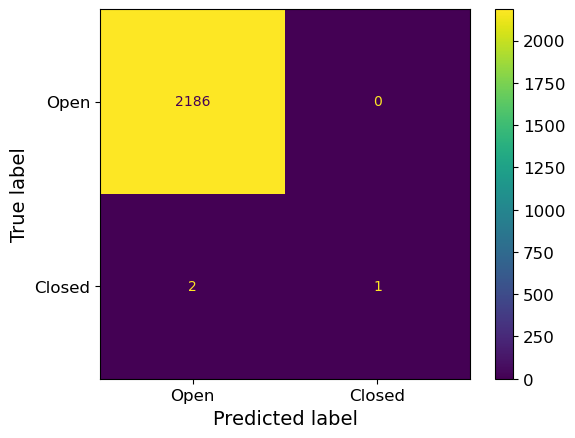

Test set accuracy score for Random Forest Model is  0.9990863407948835
Test set recall score for Random Forest Model is  0.3333333333333333
Test set precision score for Random Forest Model is  1.0
Test set F1 score for Random Forest Model is  0.5


In [38]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3= accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3= recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3= precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13= f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of data with hourly data available

In [39]:
#add hourly data max precipitation rates

hourly['time']= hourly['DATE'].dt.hour
hourly['DATE']=hourly['DATE'].dt.date

max_precipitation = hourly.groupby('DATE').apply(lambda x: x.loc[x['HPCP'].idxmax()])
max_precipitation = max_precipitation[['DATE', 'time', 'HPCP']]

max_precipitation['Max Precip. Time'] = max_precipitation['time'].astype('int')
max_precipitation['Max Precip. Rate']= max_precipitation['HPCP']

max_precipitation = max_precipitation.drop(columns = ['time', 'HPCP'])
max_precipitation.reset_index(drop=True, inplace=True)
max_precipitation['DATE']=pd.to_datetime(max_precipitation['DATE'])

max_precipitation

,DATE,Max Precip. Time,Max Precip. Rate
0,1965-01-01,23,0.06
1,1965-01-02,0,0.05
2,1965-01-07,17,0.01
3,1965-01-08,11,0.03
4,1965-01-12,20,0.01
...,...,...,...
7484,2013-12-26,0,0.00
7485,2013-12-27,0,0.00
7486,2013-12-29,7,0.00
7487,2013-12-30,18,0.02


In [40]:
whourly = pd.merge(school, max_precipitation, how='inner', on='DATE')
print(whourly.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      3374 non-null   datetime64[ns]
 1   Closure Type              3374 non-null   float64       
 2   Station                   3374 non-null   float64       
 3   PrecipitationTotal        3374 non-null   float64       
 4   SnowfallTotal             3374 non-null   float64       
 5   SnowDepth                 3374 non-null   float64       
 6   MaxTemp                   3374 non-null   int64         
 7   MinTemp                   3374 non-null   int64         
 8   WaterEqGroundSnow         3374 non-null   float64       
 9   Fog/IceFog/FreezingFog    3374 non-null   float64       
 10  Thunder                   3374 non-null   float64       
 11  Ice/Sleet                 3374 non-null   float64       
 12  Hail                

In [41]:
missing_dates2=date_range[~date_range.isin(whourly['DATE'])]
winter_missing_dates2 = missing_dates2[missing_dates2.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates2, winter_missing_dates2)
print(whourly['Closure Type'].value_counts())
#11464 missing winter weather days
#8 closures to look at now instead of 13

DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=18906, freq=None) DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=11464, freq=None)
Closure Type
0.0    3366
1.0       8
Name: count, dtype: int64


In [42]:
#create previous day's max precip. rate and time
whourly['Previous Max Precip. Rate'] = whourly['Max Precip. Rate'].shift(1)
whourly['Previous Max Precip. Time'] = whourly['Max Precip. Time'].shift(1)

whourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATE                       3374 non-null   datetime64[ns]
 1   Closure Type               3374 non-null   float64       
 2   Station                    3374 non-null   float64       
 3   PrecipitationTotal         3374 non-null   float64       
 4   SnowfallTotal              3374 non-null   float64       
 5   SnowDepth                  3374 non-null   float64       
 6   MaxTemp                    3374 non-null   int64         
 7   MinTemp                    3374 non-null   int64         
 8   WaterEqGroundSnow          3374 non-null   float64       
 9   Fog/IceFog/FreezingFog     3374 non-null   float64       
 10  Thunder                    3374 non-null   float64       
 11  Ice/Sleet                  3374 non-null   float64       
 12  Hail  

In [43]:
whourly = whourly.drop(columns=['DATE', 'School Year', 'MinTempChange', 'MaxTempChange', 'SnowfallTotalChange', 'SnowDepthChange', 'Closure_shift'])

# data correlations and more drops

In [44]:
whourly.corr()['Closure Type'].sort_values()

MaxTemp                     -0.045195
Previous_MaxTemp            -0.042873
MinTemp                     -0.031849
Previous_MinTemp            -0.030984
3DayVector_MinTemp          -0.025418
3DayVector_MaxTemp          -0.018712
Max Precip. Time            -0.017996
Day                         -0.012601
Hail                        -0.010913
Day of the Week             -0.005325
Snow Days This Year         -0.001878
Previous Early Dismissal    -0.001454
HighWinds                   -0.000839
Mist                         0.010305
Year                         0.011821
Glaze                        0.012489
Previous Max Precip. Rate    0.013654
Ice/Sleet                    0.014040
Month                        0.015861
Thunder                      0.016666
Fog/IceFog/FreezingFog       0.017953
Previous_SnowDepth           0.018718
Previous Max Precip. Time    0.021660
WaterEqGroundSnow            0.031203
Max Precip. Rate             0.031262
IceFog                       0.038703
SnowDepth   

In [45]:
ready =whourly.drop(columns=['3DayVector_MaxTemp', 'Thunder', 'Day', 'Day of the Week', 'Previous Max Precip. Rate', 'Max Precip. Rate', 'Hail', 'HighWinds', 'Glaze', 'Previous Max Precip. Time',  'Ice/Sleet', 'Station', 'Tornado', 'MaxTemp', 'Previous_MaxTemp', 'MinTemp', 'Previous_MinTemp', '3DayVector_MinTemp', 'Max Precip. Time', 'Snow Days This Year', 'Previous Early Dismissal', 'Mist', 'Year', 'Month', 'Fog/IceFog/FreezingFog', 'Previous_SnowDepth', 'WaterEqGroundSnow', 'IceFog'])

In [46]:
ready.corr()['Closure Type'].sort_values()

SnowDepth                   0.090172
Previous_SnowfallTotal      0.102913
PrecipitationTotal          0.107982
3DayVector_SnowDepth        0.153017
3DayVector_SnowfallTotal    0.341296
SnowfallTotal               0.373784
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (w/ hourly)

In [47]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (w/ hourly data)

In [49]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Cross validation score for Logistic Regression Model is  0.9826086956521738


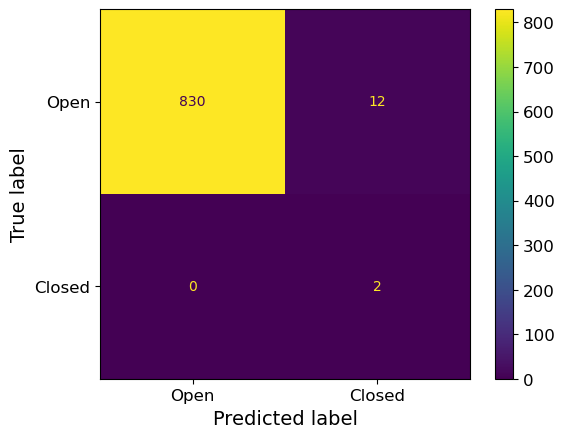

Test set accuracy score for Logistic Regression Model is  0.985781990521327
Test set recall score for Logistic Regression Model is  1.0
Test set precision score for Logistic Regression Model is  0.14285714285714285
Test set F1 score for Logistic Regression Model is  0.25


In [50]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (w/ hourly data)

In [51]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15}


In [52]:
dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = None, min_samples_leaf = 1, min_samples_split =15, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9960474308300394


/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


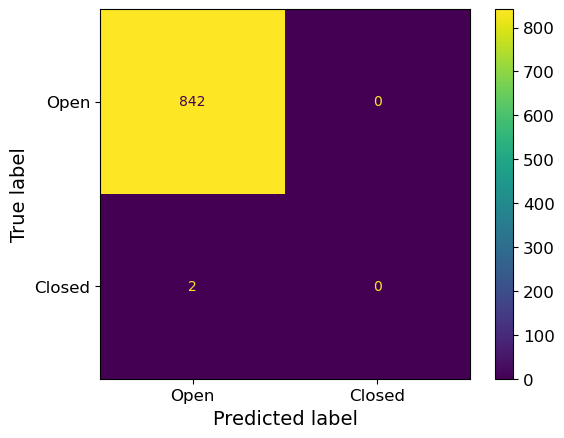

Test set accuracy score for Decision Tree Model is  0.9976303317535545
Test set recall score for Decision Tree Model is  0.0
Test set precision score for Decision Tree Model is  0.0
Test set F1 score for Decision Tree Model is  0.0


/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (w/ hourly data)

In [54]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [55]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Cross validation score for Random Forest Model is  0.9972332015810277


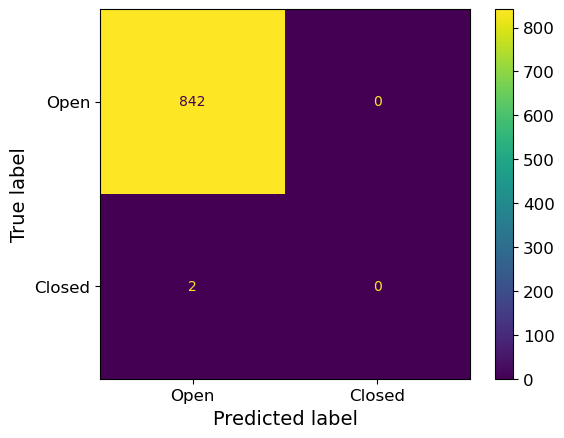

Test set accuracy score for Random Forest Model is  0.9976303317535545
Test set recall score for Random Forest Model is  0.0
Test set precision score for Random Forest Model is  0.0
Test set F1 score for Random Forest Model is  0.0


/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of just extreme weather data and school closures (more balanced data set)

In [57]:
snow = full['SnowfallTotal']>3
temp=full['MinTemp']<25
closure=full['Closure Type'] == 1

extreme_subset = full[snow|temp|closure]

extreme_subset['Closure Type'].value_counts()

Closure Type
0.0    3479
1.0      13
Name: count, dtype: int64

# data correlations and more drops

In [58]:
extreme_subset.corr()['Closure Type'].sort_values()

MaxTemp                    -0.070602
Previous_MaxTemp           -0.048683
MinTemp                    -0.043783
Previous_MinTemp           -0.034160
3DayVector_MaxTemp         -0.031235
3DayVector_MinTemp         -0.015394
Day of the Week            -0.010969
Hail                       -0.004147
Month                      -0.000288
Glaze                       0.002878
WaterEqGroundSnow           0.003676
Ice/Sleet                   0.015394
Mist                        0.019803
Day                         0.024637
Previous_SnowDepth          0.025970
IceFog                      0.027042
Fog/IceFog/FreezingFog      0.027258
Year                        0.042011
School Year                 0.042094
SnowDepth                   0.066505
Previous_SnowfallTotal      0.077311
Previous Early Dismissal    0.111001
3DayVector_SnowDepth        0.114137
Thunder                     0.119984
Snow Days This Year         0.167035
3DayVector_SnowfallTotal    0.206472
PrecipitationTotal          0.260954
S

In [59]:
ready =extreme_subset.drop(columns=['3DayVector_MaxTemp',  'Day', 'Day of the Week', '3DayVector_MinTemp','Hail', 'Ice/Sleet', 'HighWinds', 'Glaze', 'Mist', 'WaterEqGroundSnow', 'Month', 'IceFog', 'Previous_MaxTemp', 'MinTemp', 'Previous_MinTemp', 'Previous_SnowDepth', 'Fog/IceFog/FreezingFog', 'Year', 'School Year', 'Station', 'Tornado'])

In [60]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.070602
SnowDepth                   0.066505
Previous_SnowfallTotal      0.077311
Previous Early Dismissal    0.111001
3DayVector_SnowDepth        0.114137
Thunder                     0.119984
Snow Days This Year         0.167035
3DayVector_SnowfallTotal    0.206472
PrecipitationTotal          0.260954
SnowfallTotal               0.285812
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (for extreme subset)

In [61]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme subset)

In [63]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.9763285659968997


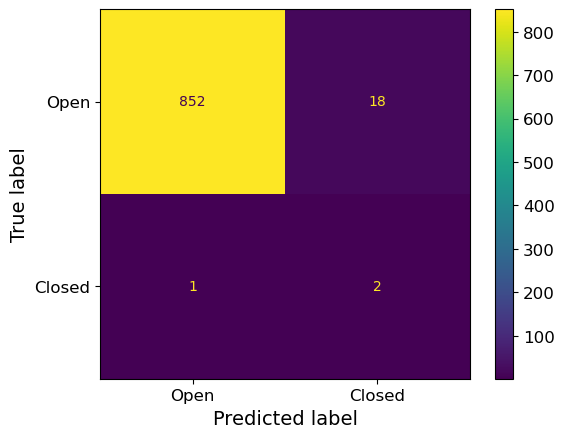

Test set accuracy score for Logistic Regression Model is  0.9782359679266895
Test set recall score for Logistic Regression Model is  0.6666666666666666
Test set precision score for Logistic Regression Model is  0.1
Test set F1 score for Logistic Regression Model is  0.1739130434782609


In [64]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme subset)

In [65]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [66]:
dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_leaf = 2, min_samples_split =2, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9950381679389313


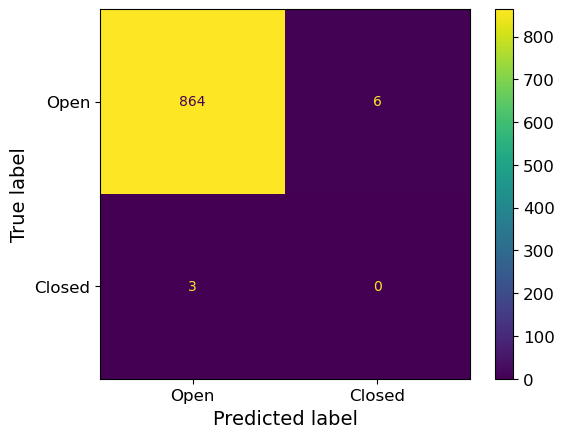

Test set accuracy score for Decision Tree Model is  0.9896907216494846
Test set recall score for Decision Tree Model is  0.0
Test set precision score for Decision Tree Model is  0.0
Test set F1 score for Decision Tree Model is  0.0


In [67]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme subset)

In [68]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [69]:
rnd_clf = RandomForestClassifier(n_estimators = 150, criterion = 'gini', max_depth = None, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9961832061068702


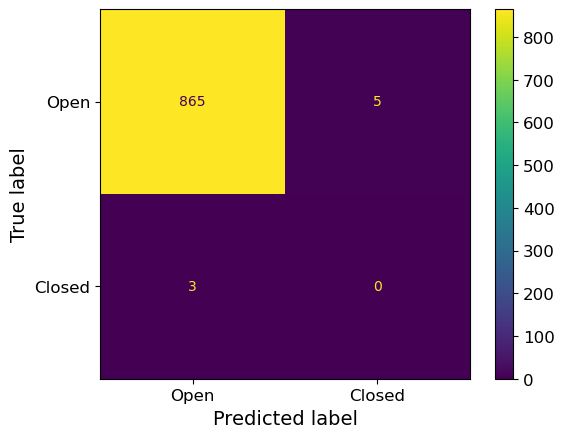

Test set accuracy score for Random Forest Model is  0.9908361970217641
Test set recall score for Random Forest Model is  0.0
Test set precision score for Random Forest Model is  0.0
Test set F1 score for Random Forest Model is  0.0


In [70]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of just extreme weather data that also contains hourly data

In [71]:
snow = whourly['SnowfallTotal']>3
temp=whourly['MinTemp']<25
closure=whourly['Closure Type'] == 1

extremehourly_subset = whourly[snow|temp|closure]

extremehourly_subset['Previous Max Precip. Time']= extremehourly_subset['Previous Max Precip. Time'].fillna(0)

extremehourly_subset['Closure Type'].value_counts()

/var/folders/fh/dvn_79bs6b58szfg1vfz4g740000gn/T/ipykernel_5430/3476903499.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremehourly_subset['Previous Max Precip. Time']= extremehourly_subset['Previous Max Precip. Time'].fillna(0)


Closure Type
0.0    1185
1.0       8
Name: count, dtype: int64

# data correlations and more drops

In [72]:
extremehourly_subset.corr()['Closure Type'].sort_values()

Max Precip. Time            -0.020855
3DayVector_MaxTemp          -0.019471
Day                         -0.016222
Previous_SnowDepth          -0.013879
3DayVector_MinTemp          -0.011262
Day of the Week             -0.009614
Hail                        -0.008954
Snow Days This Year         -0.005330
Previous Early Dismissal    -0.004125
Glaze                        0.003760
MaxTemp                      0.006679
Previous_MaxTemp             0.007348
Ice/Sleet                    0.014748
WaterEqGroundSnow            0.015974
Mist                         0.017561
Year                         0.018123
Previous_MinTemp             0.031029
IceFog                       0.032132
Fog/IceFog/FreezingFog       0.040660
Month                        0.046062
Previous Max Precip. Time    0.047823
MinTemp                      0.054261
SnowDepth                    0.072028
Previous Max Precip. Rate    0.095994
Previous_SnowfallTotal       0.096871
Thunder                      0.163437
3DayVector_S

In [73]:
ready =extremehourly_subset.drop(columns=['3DayVector_MinTemp', '3DayVector_MaxTemp',  'Day of the Week', 'Month', 'Day', 'Hail', 'Ice/Sleet', 'Previous_SnowDepth', 'Glaze', 'Mist', 'Year', 'Max Precip. Time', 'Snow Days This Year', 'MaxTemp', 'Previous_MaxTemp', 'WaterEqGroundSnow', 'Previous Early Dismissal', 'Previous_MinTemp', 'IceFog', 'Fog/IceFog/FreezingFog', 'Previous Max Precip. Time', 'Station', 'Tornado', 'HighWinds'])

In [74]:
ready.corr()['Closure Type'].sort_values()

MinTemp                      0.054261
SnowDepth                    0.072028
Previous Max Precip. Rate    0.095994
Previous_SnowfallTotal       0.096871
Thunder                      0.163437
3DayVector_SnowDepth         0.164446
Max Precip. Rate             0.238649
3DayVector_SnowfallTotal     0.355764
PrecipitationTotal           0.358401
SnowfallTotal                0.391570
Closure Type                 1.000000
Name: Closure Type, dtype: float64

In [75]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193 entries, 1 to 3373
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Closure Type               1193 non-null   float64
 1   PrecipitationTotal         1193 non-null   float64
 2   SnowfallTotal              1193 non-null   float64
 3   SnowDepth                  1193 non-null   float64
 4   MinTemp                    1193 non-null   int64  
 5   Thunder                    1193 non-null   float64
 6   Previous_SnowfallTotal     1193 non-null   float64
 7   3DayVector_SnowfallTotal   1193 non-null   float64
 8   3DayVector_SnowDepth       1193 non-null   float64
 9   Max Precip. Rate           1193 non-null   float64
 10  Previous Max Precip. Rate  1193 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 111.8 KB


# resplit data (for extreme hourly subset)

In [76]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme hourly subset)

In [78]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

from sklearn.metrics import accuracy_score
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print ('Cross validation score for Logistic Regression Model is ' , score)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Cross validation score for Logistic Regression Model is  0.9619475655430711


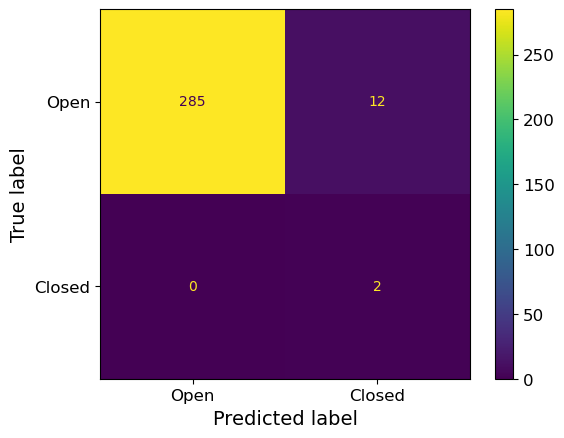

Test set accuracy score for Logistic Regression Model is  0.959866220735786
Test set recall score for Logistic Regression Model is  1.0
Test set precision score for Logistic Regression Model is  0.14285714285714285
Test set F1 score for Logistic Regression Model is  0.25


In [79]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme hourly subset)

In [80]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [81]:
dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = None, min_samples_leaf = 1, min_samples_split =10, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9877153558052434


/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


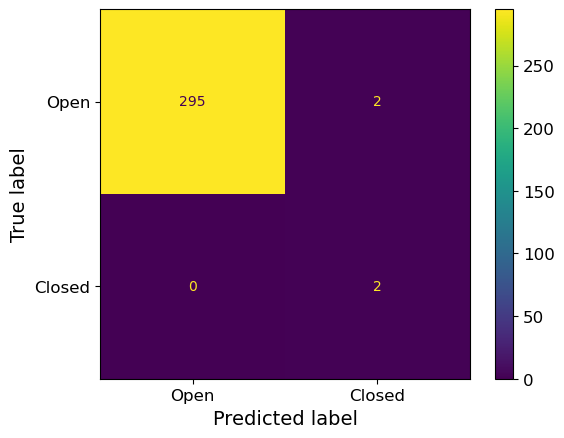

Test set accuracy score for Decision Tree Model is  0.9933110367892977
Test set recall score for Decision Tree Model is  1.0
Test set precision score for Decision Tree Model is  0.5
Test set F1 score for Decision Tree Model is  0.6666666666666666


In [82]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme hourly subset)

In [83]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [84]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = None, min_samples_leaf = 1, min_samples_split =10, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Cross validation score for Random Forest Model is  0.9899375780274656


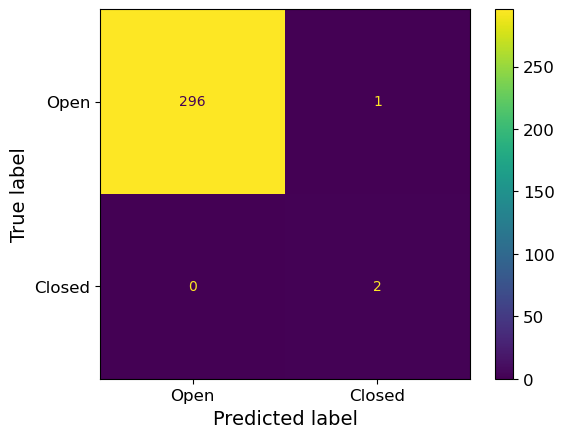

Test set accuracy score for Random Forest Model is  0.9966555183946488
Test set recall score for Random Forest Model is  1.0
Test set precision score for Random Forest Model is  0.6666666666666666
Test set F1 score for Logistic Random Forest is  0.8


In [85]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Logistic Random Forest is ' , f13)